In [1]:
import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
import time

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from Bio import Phylo

from interpretable_tsne.tsne import TSNE

In [2]:
# Load dataframes:
full_df = pd.read_csv('../results/sim_data_attrs.csv')
pvals_df = pd.read_csv('../results/sim_data_pvalues.csv')

## Grouped BoxPlot

### Look at Averages

In [3]:
def plot_2_cluster_agg(full_df, colname, avg_over=True, set_y_log=False):
    if avg_over:
        df_2_cluster = full_df[full_df['Num Cluster'] == 2].groupby(['Dataset Name', 'Class'])[['{} {}'.format(colname, i) for i in range(10)]].mean()
        df_2_cluster['Effect 1'] = full_df[full_df['Num Cluster'] == 2].groupby(['Dataset Name', 'Class'])['Effect 1'].first()
        df_2_cluster = df_2_cluster.reset_index().drop(columns='Dataset Name').melt(id_vars=['Effect 1', 'Class'])
    else:
        df_2_cluster = full_df[full_df['Num Cluster'] == 2][['{} {}'.format(colname, i) for i in range(10)]]
        df_2_cluster['Effect 1'] = full_df[full_df['Num Cluster'] == 2]['Effect 1']
        df_2_cluster[['Dataset Name', 'Class']] = full_df[full_df['Num Cluster'] == 2][['Dataset Name', 'Class']]
        df_2_cluster = df_2_cluster.drop(columns='Dataset Name').melt(id_vars=['Effect 1', 'Class'])

    df_2_cluster['Is Attr 1'] = df_2_cluster.apply(lambda row: row['variable'] == '{} 0'.format(colname), axis=1)

    fig, ax = plt.subplots(figsize=(30, 10))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.boxplot(y='value', x='Effect 1', hue='Class', data=df_2_cluster, hue_order=[0.0, 1.0, 2.0, 3.0], boxprops={'alpha': 0.4})
    if set_y_log:
        _ = ax.set_yscale('log')
    
    if avg_over:
        alpha = 1
    else:
        alpha = 0.2
    
    sns.stripplot(data=df_2_cluster[(df_2_cluster['Is Attr 1']) & (~pd.isna(df_2_cluster['Effect 1']))], 
                  y='value', 
                  x='Effect 1', 
                  hue='Class', 
                  hue_order=[0.0, 1.0, 2.0, 3.0], 
                  dodge=True,
                  ax=ax,
                  alpha=alpha)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[4]), (handles[1], handles[5]), (handles[2], handles[6]), (handles[3], handles[7])],
              labels=['Class 1', 'Class 2', 'Class 3', 'Class 4'],
              loc='center left', bbox_to_anchor=(1, 0.5), handlelength=4,
              handler_map={tuple: HandlerTuple(ndivide=None)})
    _ = ax.set_xlabel('Main Effect size')
    if avg_over:
        _ = ax.set_ylabel('{} (over seed)'.format(colname))
    else:
        _ = ax.set_ylabel('{}'.format(colname))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)

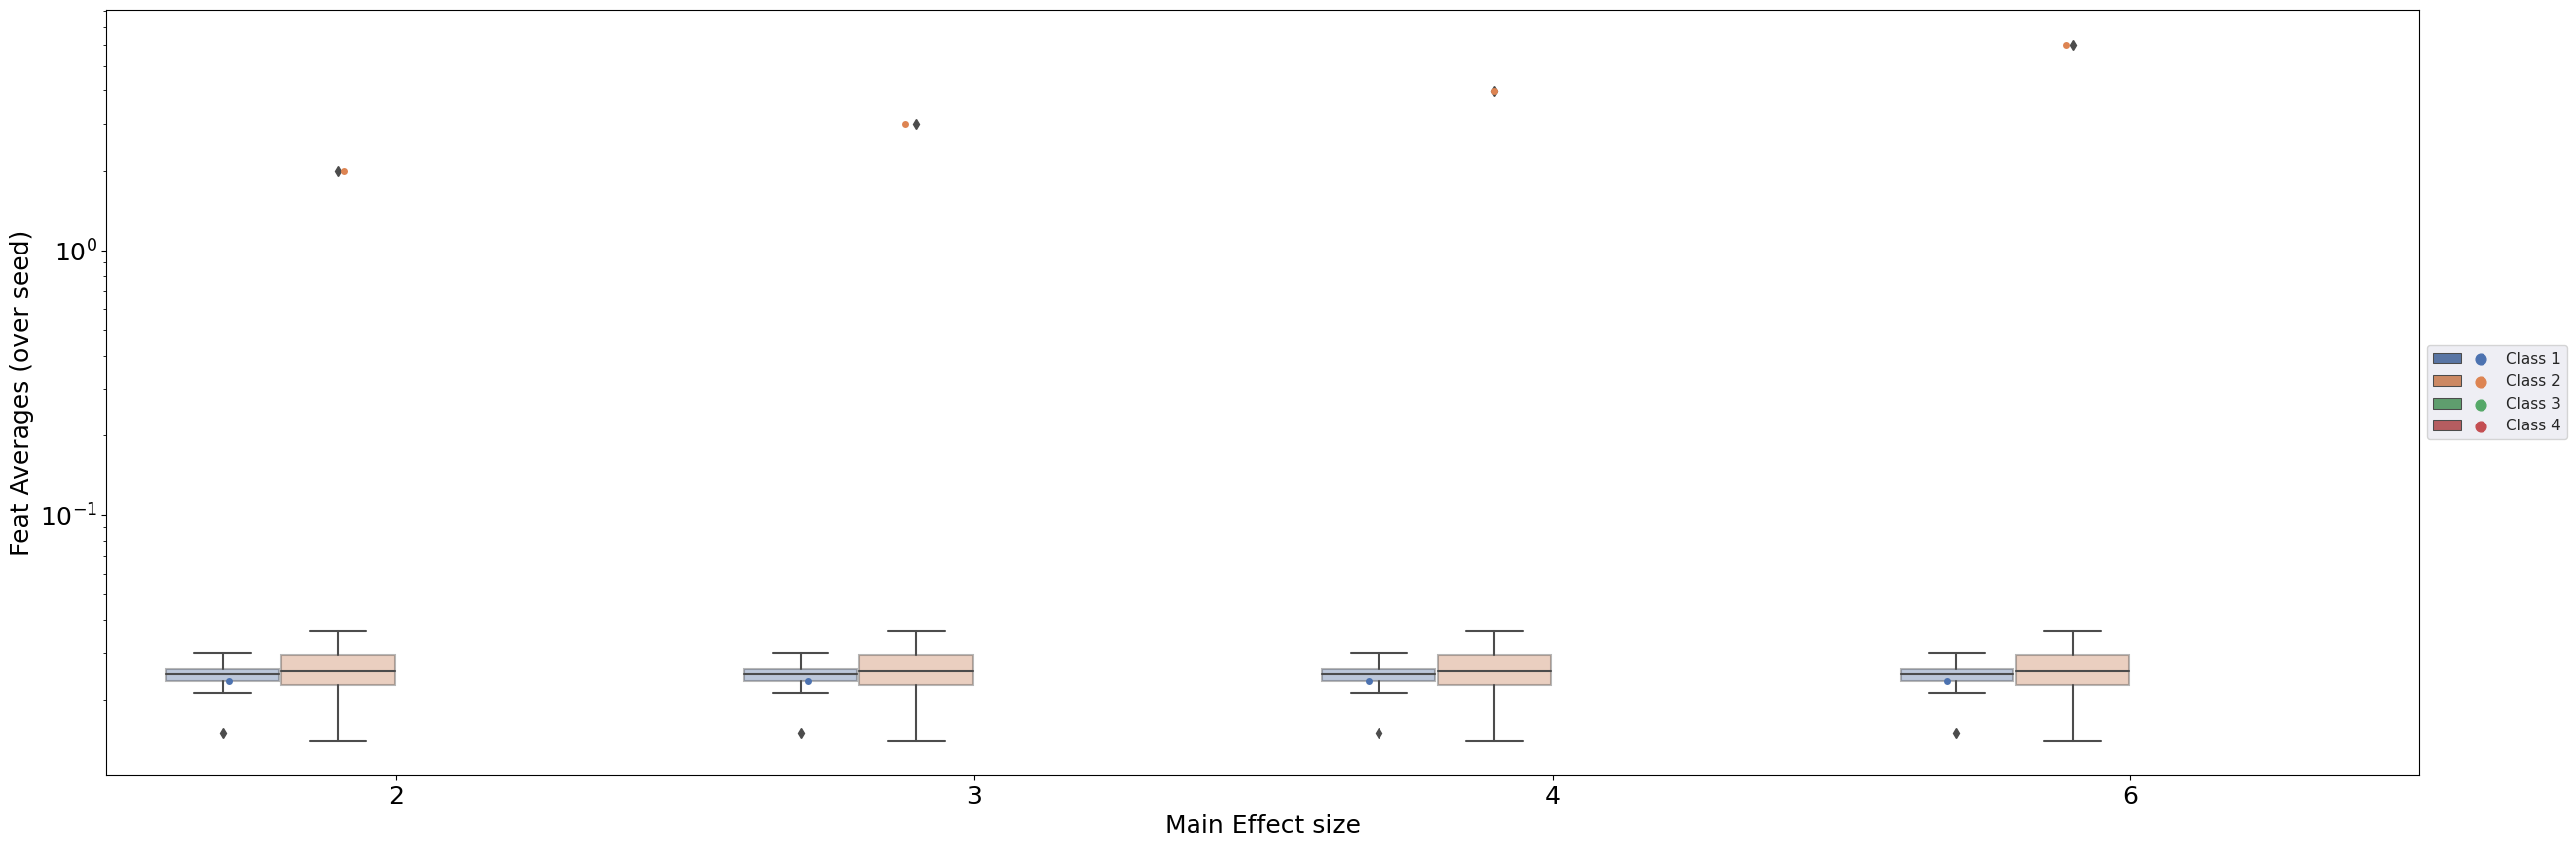

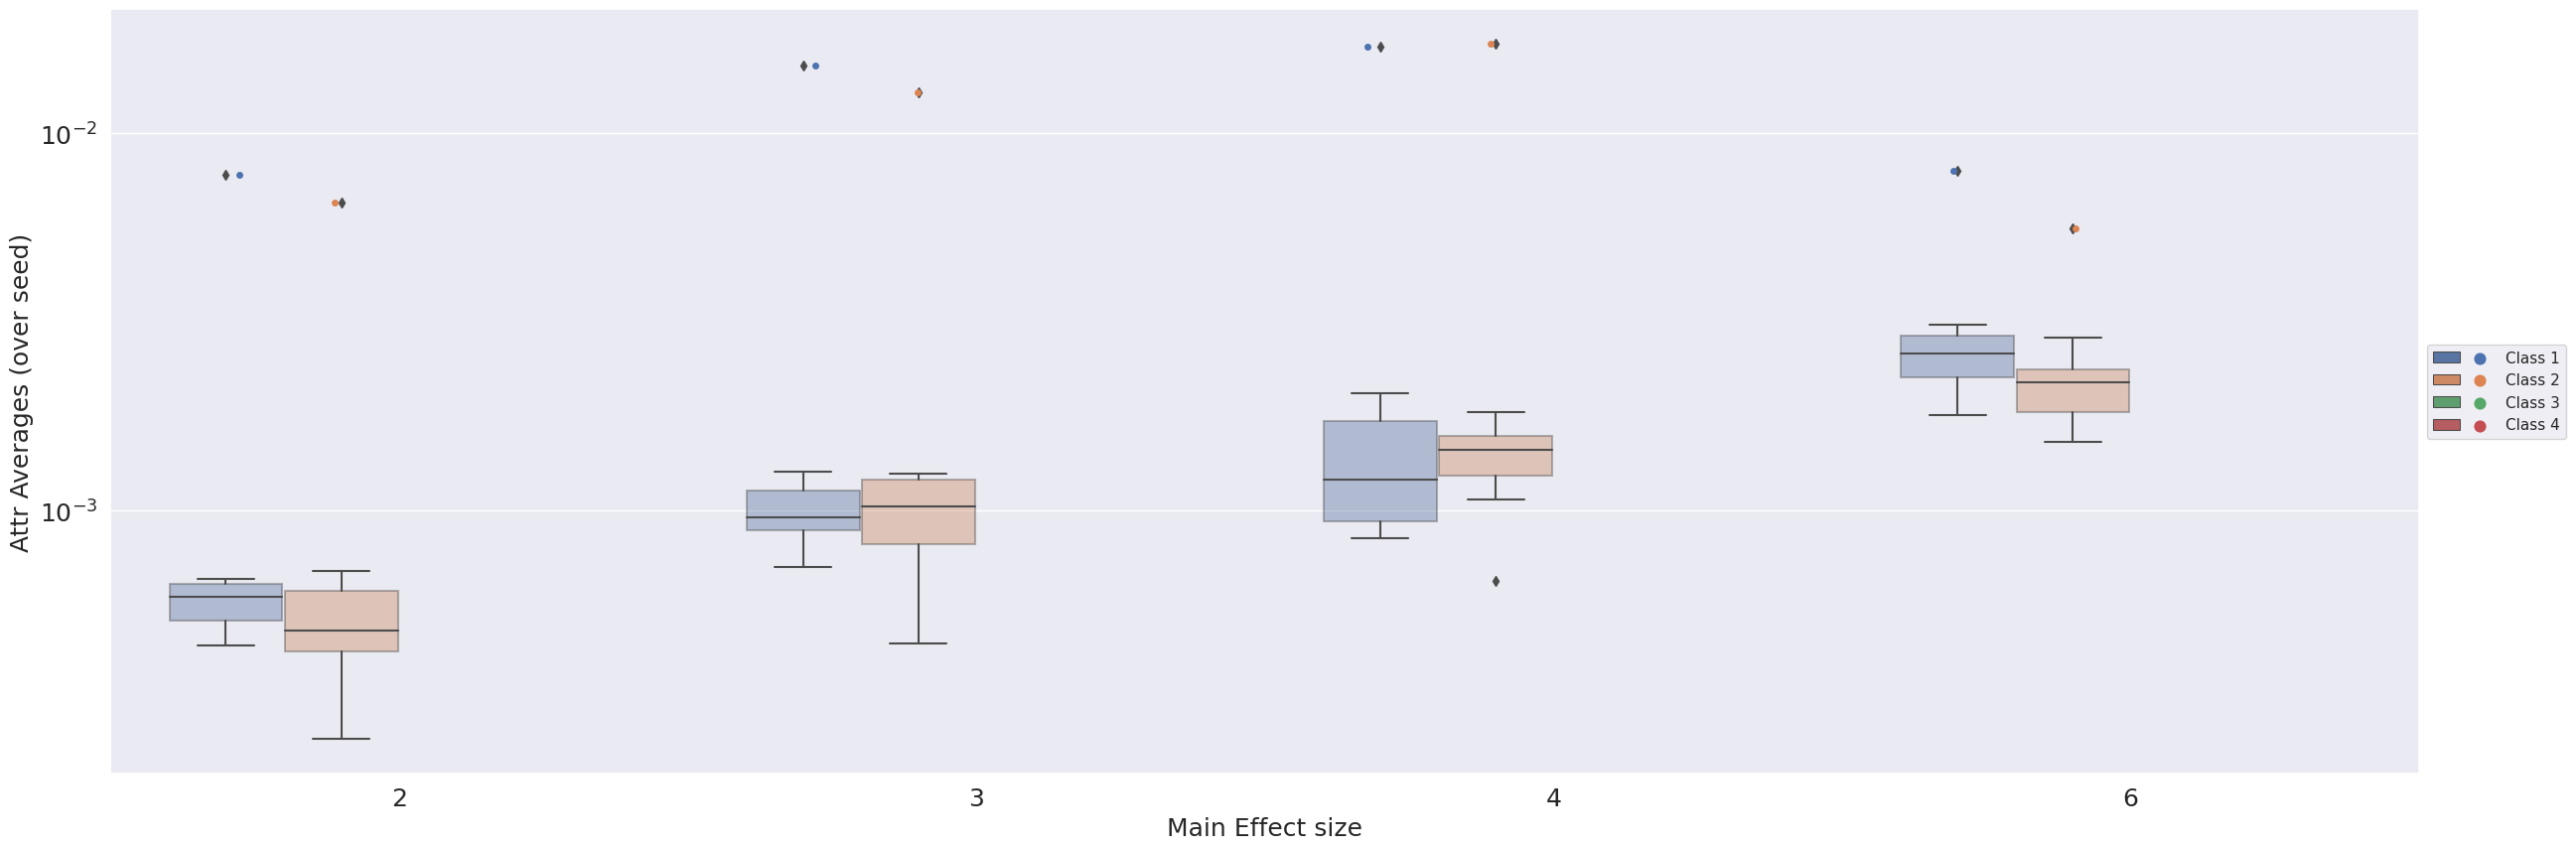

In [4]:
plot_2_cluster_agg(full_df, 'Feat Averages', set_y_log=True)
plot_2_cluster_agg(full_df, 'Attr Averages', set_y_log=True)

### Now Lets Look at all the runs

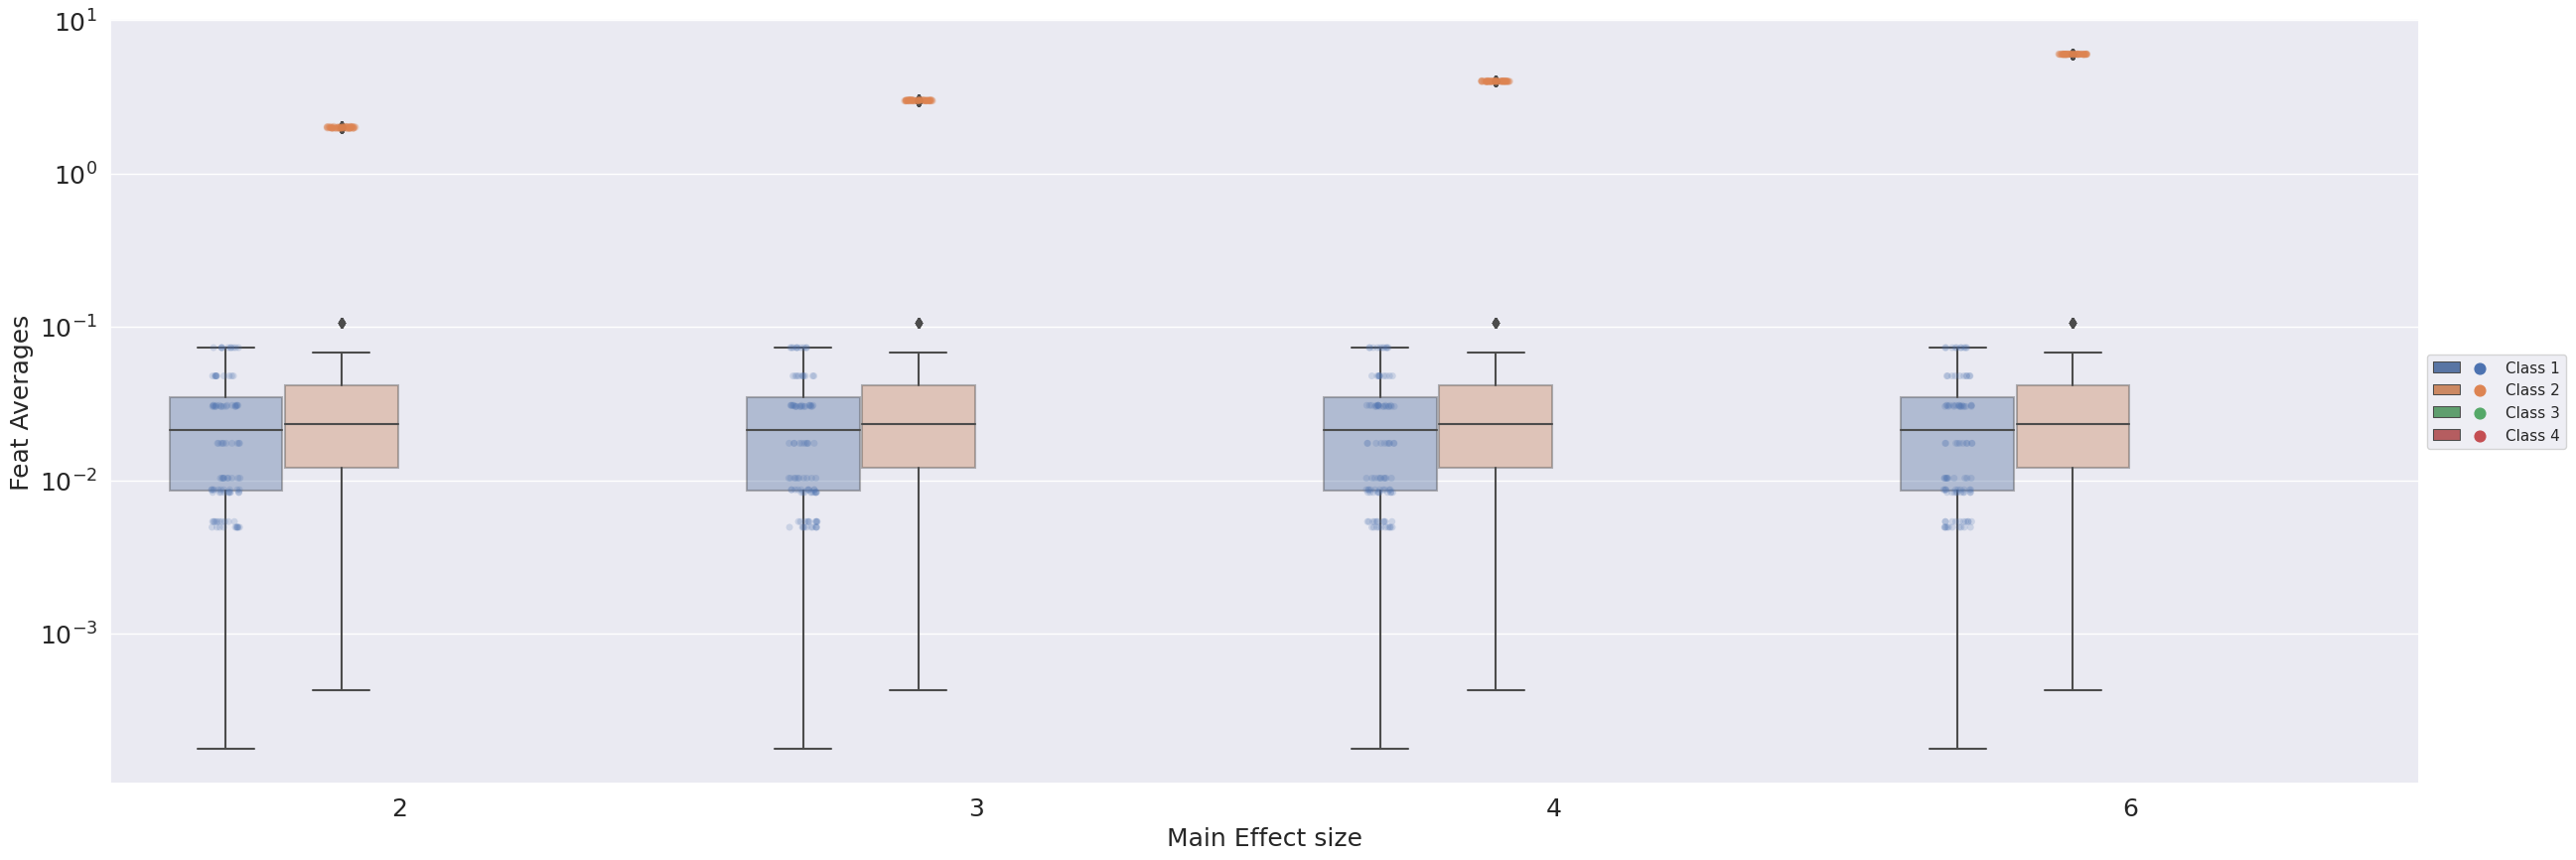

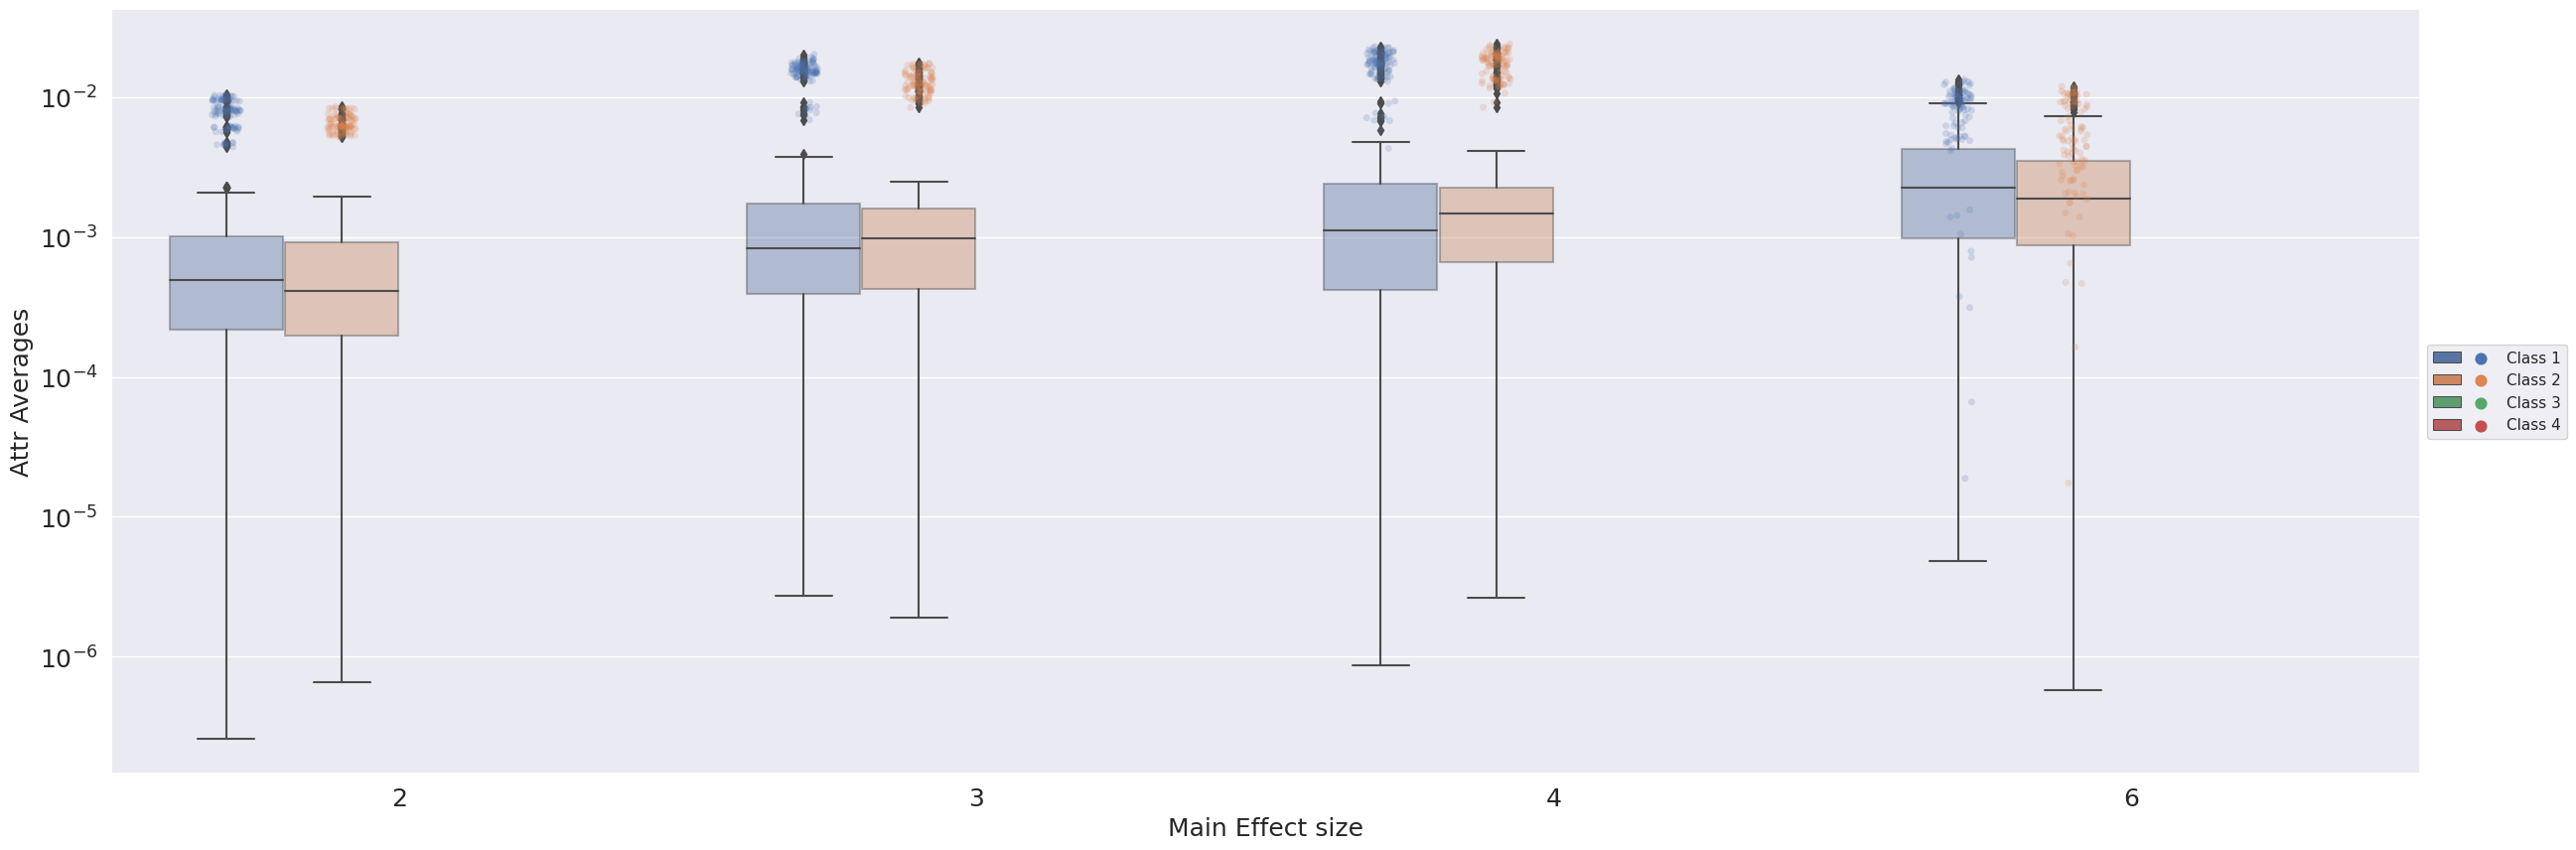

In [5]:
plot_2_cluster_agg(full_df, 'Feat Averages', False, set_y_log=True)
plot_2_cluster_agg(full_df, 'Attr Averages', False, set_y_log=True)

### Look at Averages

In [6]:
def plot_4_cluster_agg(full_df, colname, avg_over=True, set_y_log=False, plot_col='Effect 1', title=None, fig_name=None):
    if avg_over:
        df_4_cluster = full_df[full_df['Num Cluster'] == 4].groupby(['Dataset Name', 'Class'])[['{} {}'.format(colname, i) for i in range(10)]].mean()
        df_4_cluster['Effect 1'] = full_df[full_df['Num Cluster'] == 4].groupby(['Dataset Name', 'Class'])['Effect 1'].first()
        df_4_cluster['Effect 2'] = full_df[full_df['Num Cluster'] == 4].groupby(['Dataset Name', 'Class'])['Effect 2'].first()
        df_4_cluster = df_4_cluster.reset_index().drop(columns='Dataset Name').melt(id_vars=['Effect 1', 'Effect 2', 'Class'])
    else:
        df_4_cluster = full_df[full_df['Num Cluster'] == 4][['{} {}'.format(colname, i) for i in range(10)]]
        df_4_cluster[['Effect 1', 'Effect 2', 'Class']] = full_df[['Effect 1', 'Effect 2', 'Class']]
        df_4_cluster = df_4_cluster.melt(id_vars=['Effect 1', 'Effect 2', 'Class'])

    df_4_cluster['Is Attr 1'] = df_4_cluster.apply(lambda row: row['variable'] == '{} 0'.format(colname), axis=1)
    df_4_cluster['Is Attr 2'] = df_4_cluster.apply(lambda row: row['variable'] == '{} 1'.format(colname), axis=1)
    df_4_cluster['Is Attr 3'] = df_4_cluster.apply(lambda row: row['variable'] == '{} 2'.format(colname), axis=1)
    
    cond1 = ((df_4_cluster['Class'] == 0.0) & ((df_4_cluster['Is Attr 1']) | df_4_cluster['Is Attr 2']))
    cond2 = ((df_4_cluster['Class'] == 1.0) & ((df_4_cluster['Is Attr 1']) | df_4_cluster['Is Attr 2']))
    cond3 = ((df_4_cluster['Class'] == 2.0) & ((df_4_cluster['Is Attr 1']) | df_4_cluster['Is Attr 3']))
    cond4 = ((df_4_cluster['Class'] == 3.0) & ((df_4_cluster['Is Attr 1']) | df_4_cluster['Is Attr 3']))

    if avg_over:
        alpha = 1
    else:
        alpha = 0.2

    fig, ax = plt.subplots(figsize=(10*len(df_4_cluster[plot_col].unique()), 10))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.boxplot(y='value', x=plot_col, hue='Class', data=df_4_cluster, hue_order=[0.0, 1.0, 2.0, 3.0], boxprops={'alpha': 0.4})
    if set_y_log:
        _ = ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    sns.stripplot(data=df_4_cluster[(cond1 | cond2 | cond3 | cond4)], 
                  y='value', 
                  x=plot_col, 
                  hue='Class', 
                  hue_order=[0.0, 1.0, 2.0, 3.0], 
                  dodge=True, 
                  ax=ax,
                  alpha=alpha)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[4]), (handles[1], handles[5]), (handles[2], handles[6]), (handles[3], handles[7])],
              labels=['Class 1', 'Class 2', 'Class 3', 'Class 4'],
              loc='center left', bbox_to_anchor=(1, 0.5), handlelength=4,
              handler_map={tuple: HandlerTuple(ndivide=None)})
    _ = ax.set_xlabel('{} size'.format(plot_col))
    if avg_over:
        _ = ax.set_ylabel('{} (over seed)'.format(colname))
    else:
        _ = ax.set_ylabel('{}'.format(colname))

    if title:
        ax.set_title(title, fontsize=20)
        
    
    if fig_name:
        fig = ax.get_figure()
        fig.savefig(fig_name, dpi=600, bbox_inches='tight')

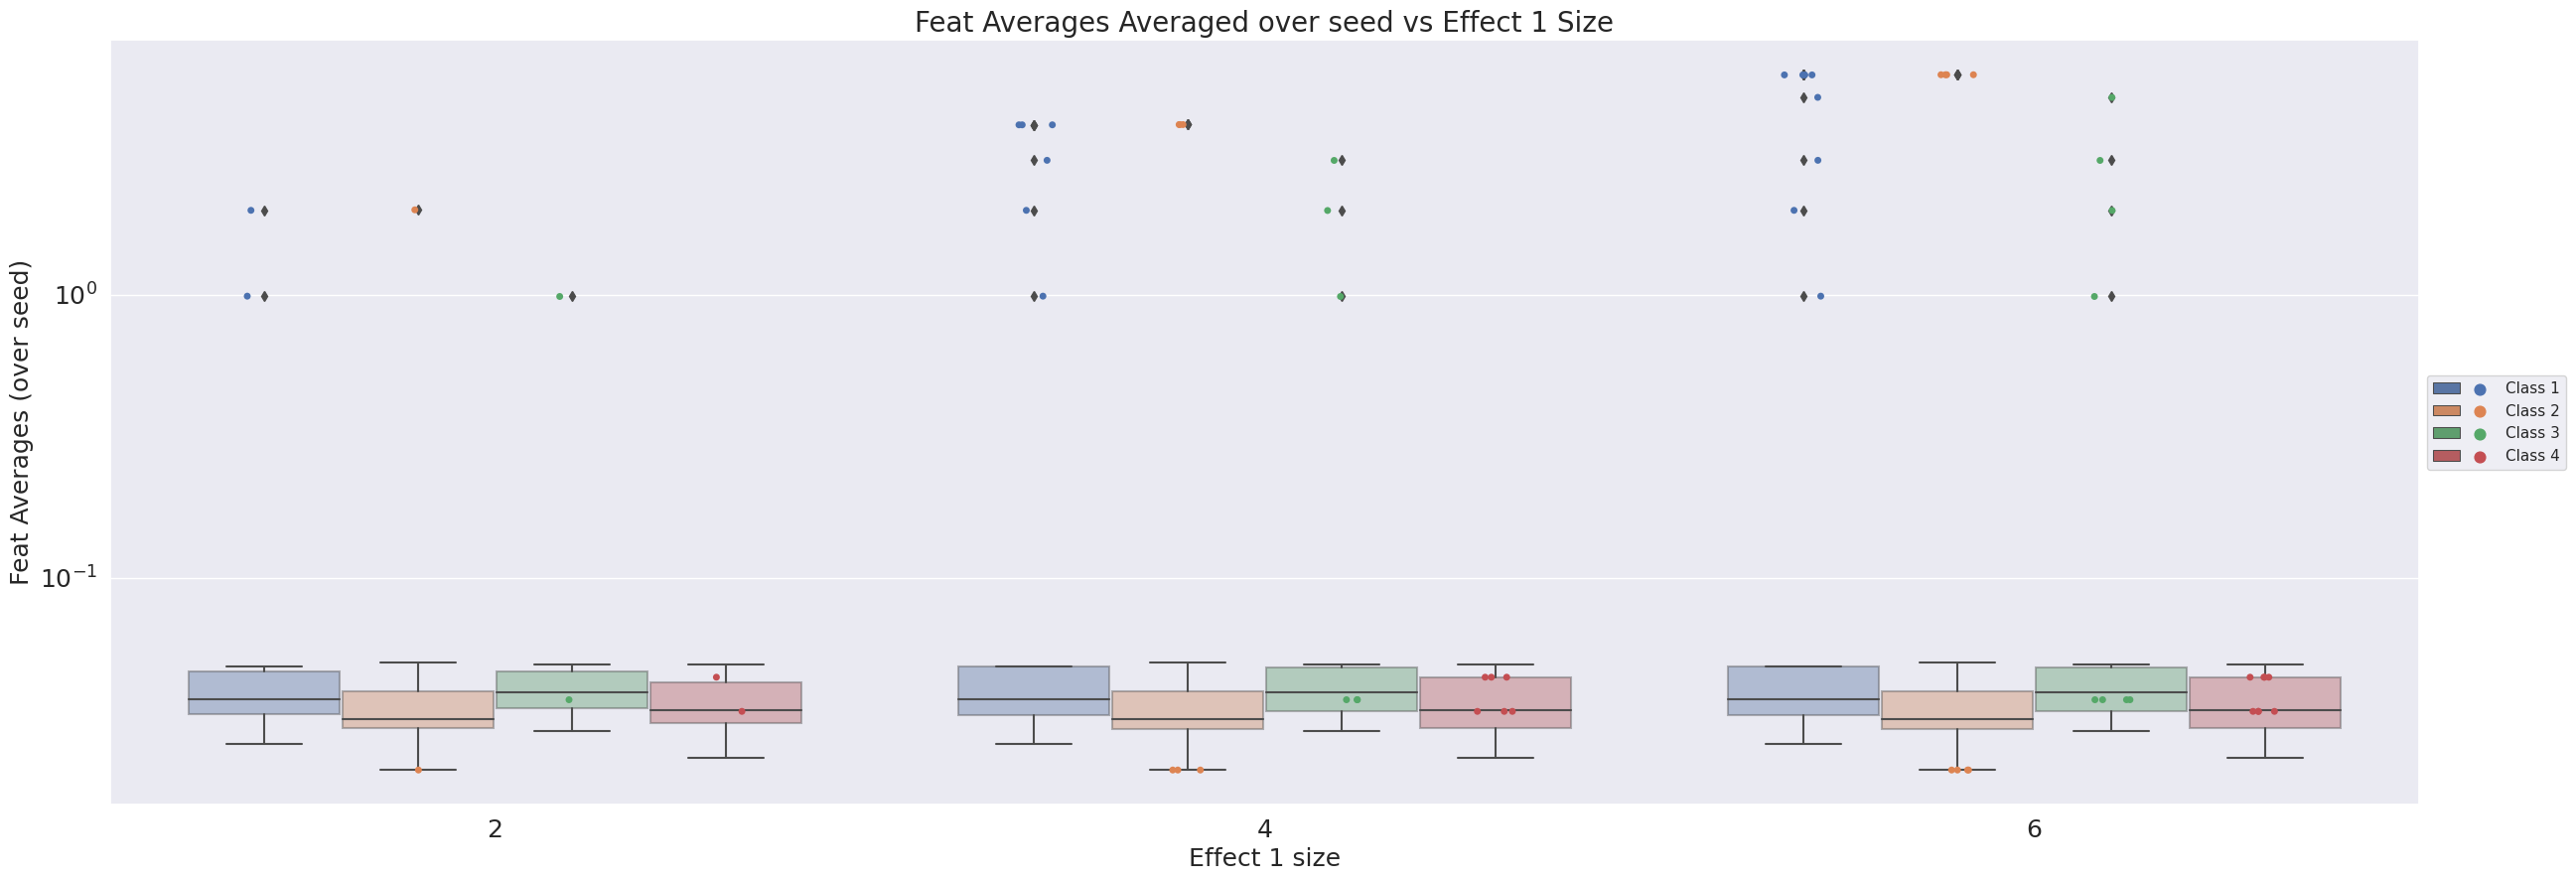

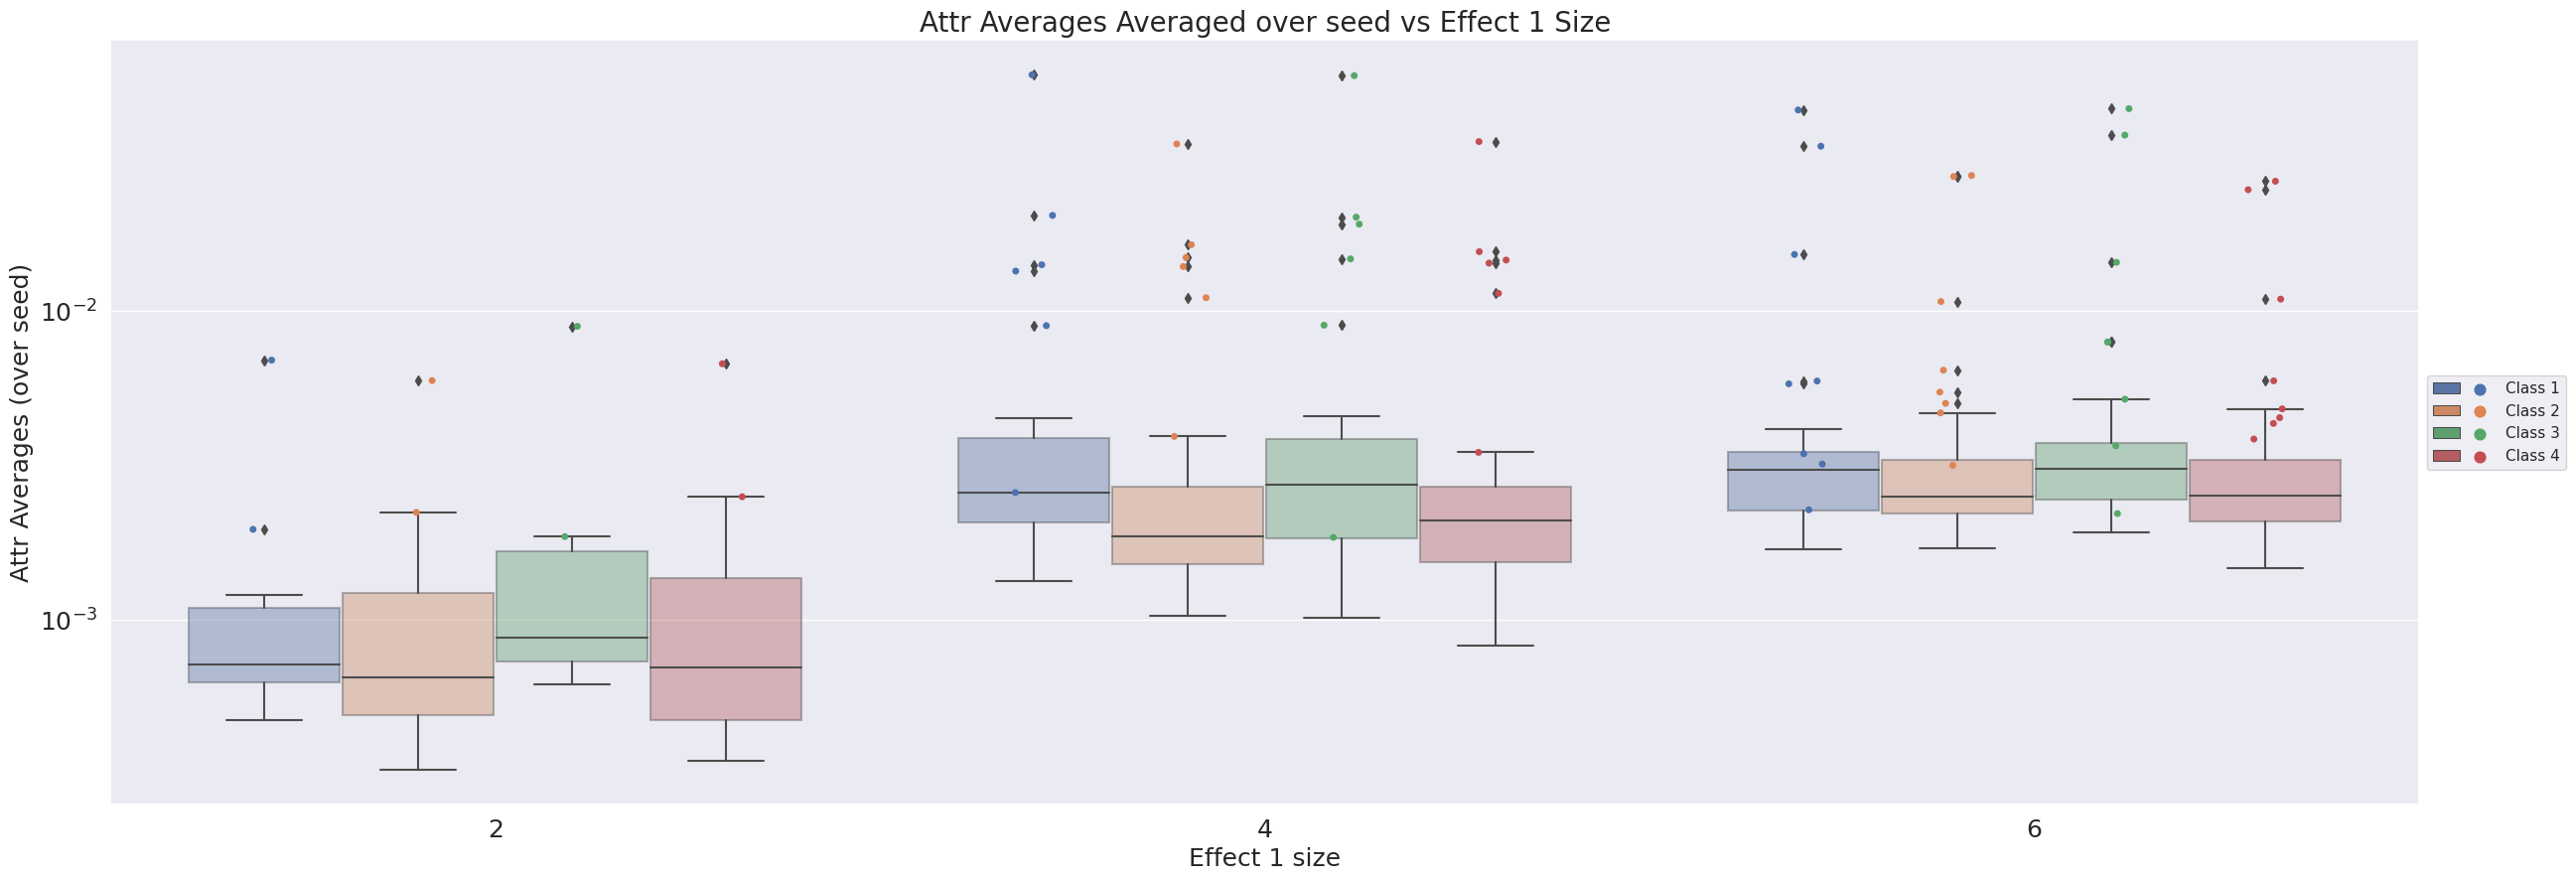

In [7]:
plot_4_cluster_agg(full_df, 'Feat Averages', avg_over=True, set_y_log=True, plot_col='Effect 1', title='Feat Averages Averaged over seed vs Effect 1 Size')
plot_4_cluster_agg(full_df, 'Attr Averages', avg_over=True, set_y_log=True, plot_col='Effect 1', title='Attr Averages Averaged over seed vs Effect 1 Size')

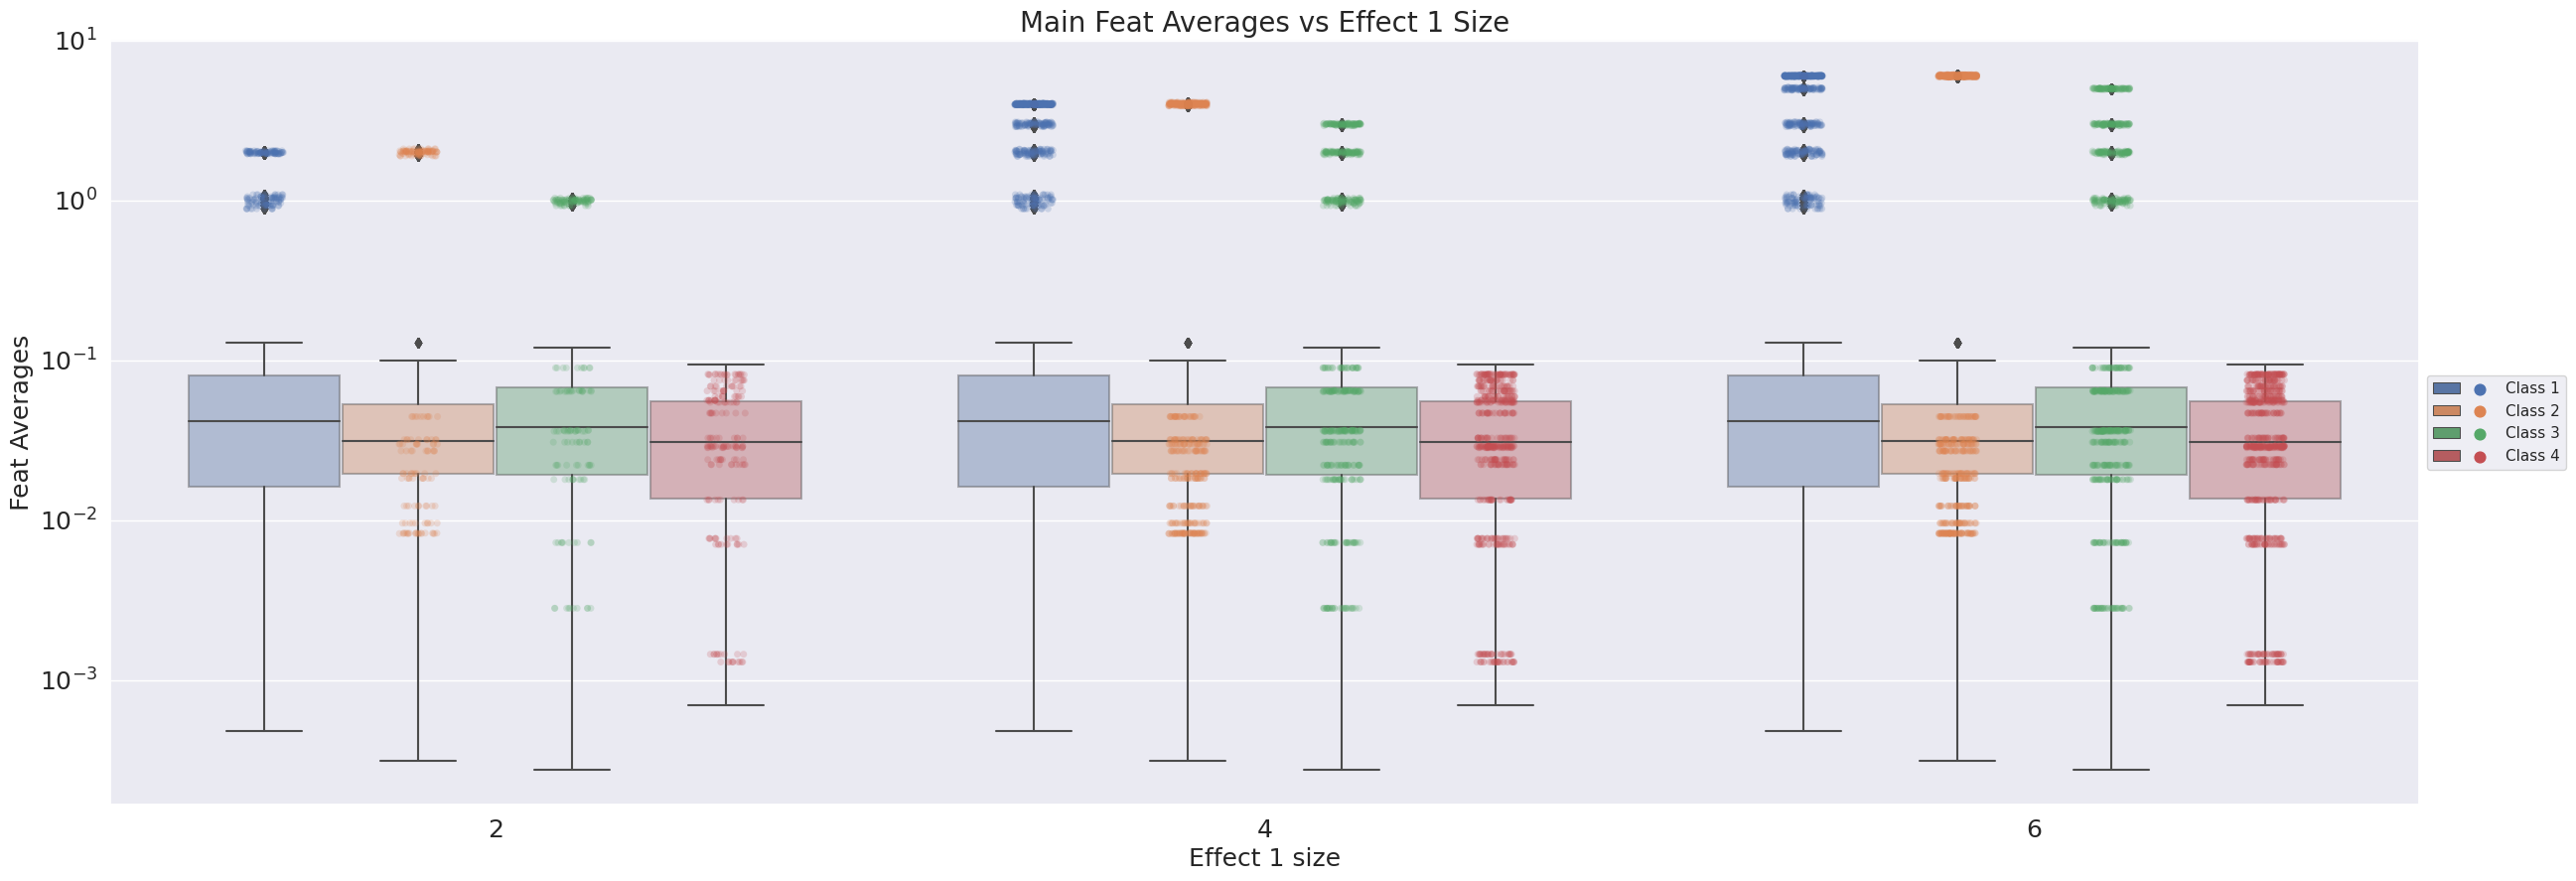

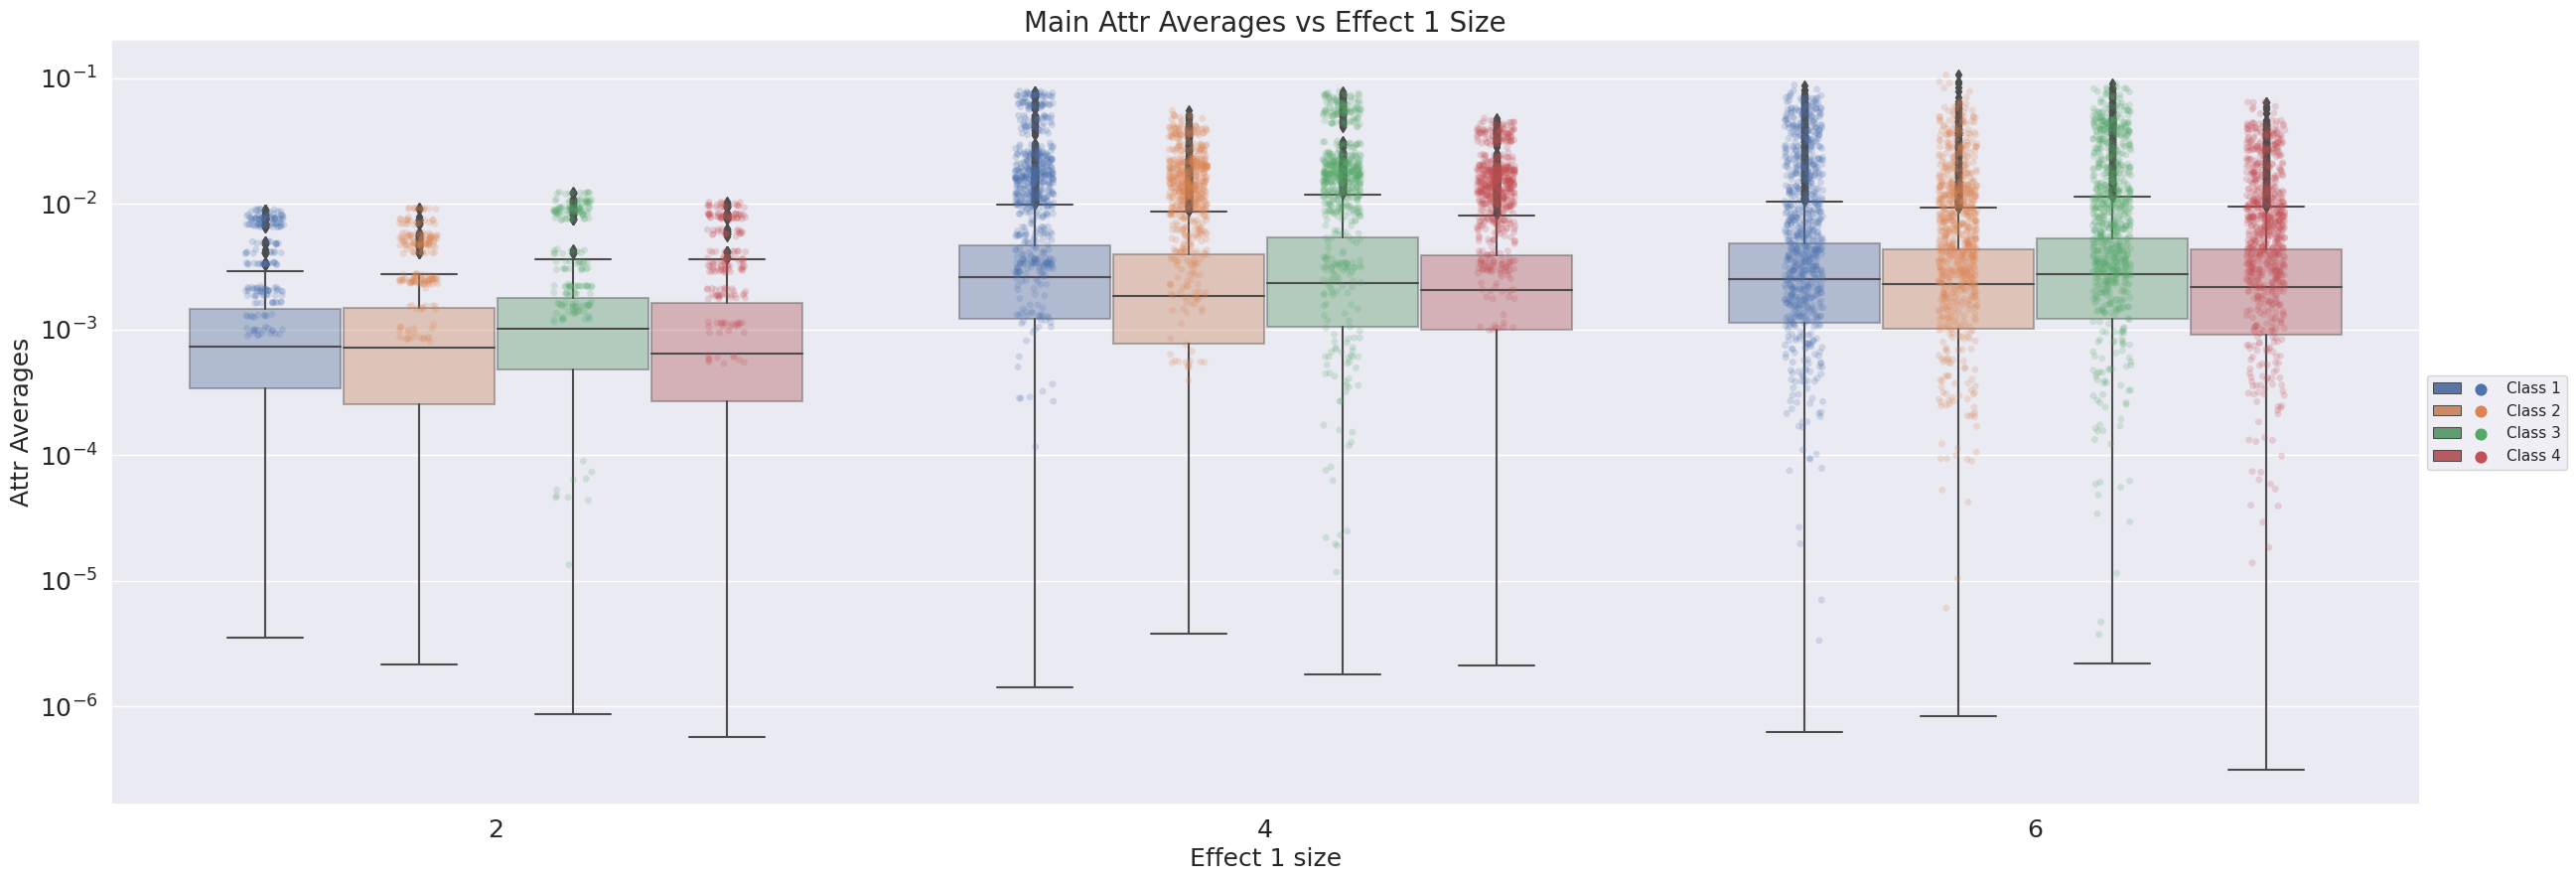

In [8]:
plot_4_cluster_agg(full_df, 'Feat Averages', avg_over=False, set_y_log=True, plot_col='Effect 1', title='Main Feat Averages vs Effect 1 Size')
plot_4_cluster_agg(full_df, 'Attr Averages', avg_over=False, set_y_log=True, plot_col='Effect 1', title='Main Attr Averages vs Effect 1 Size')

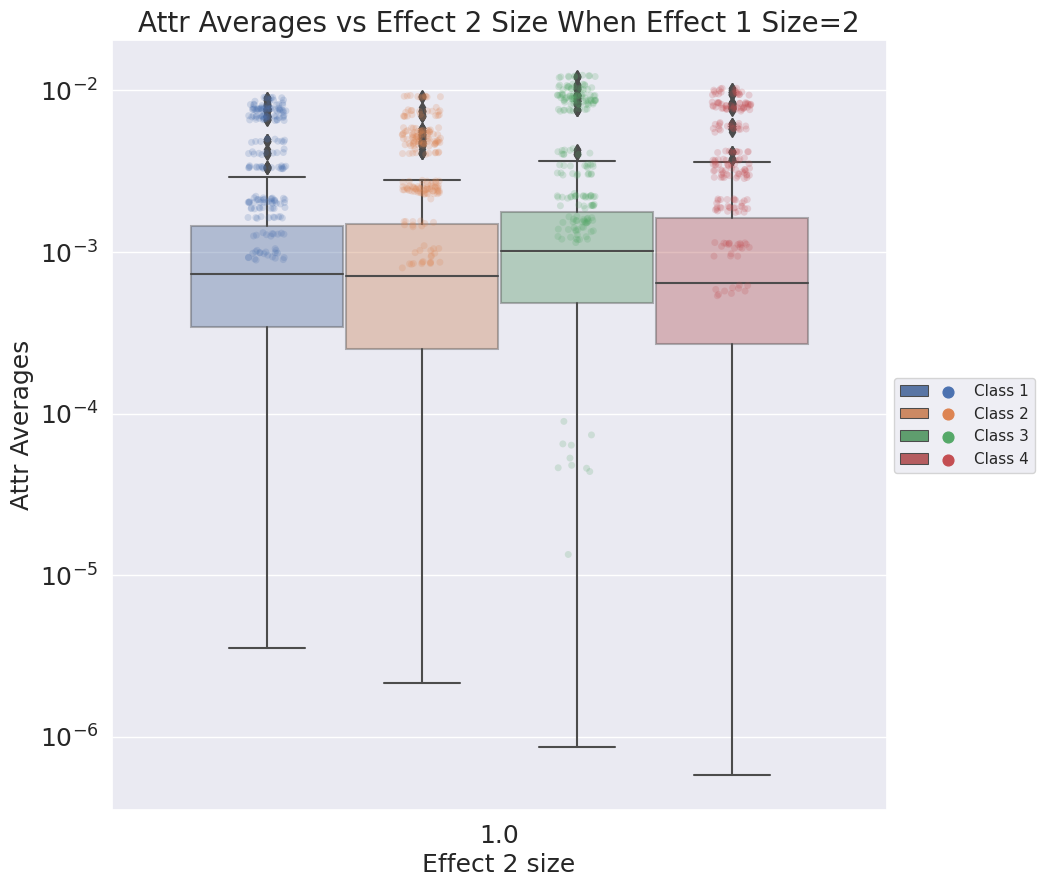

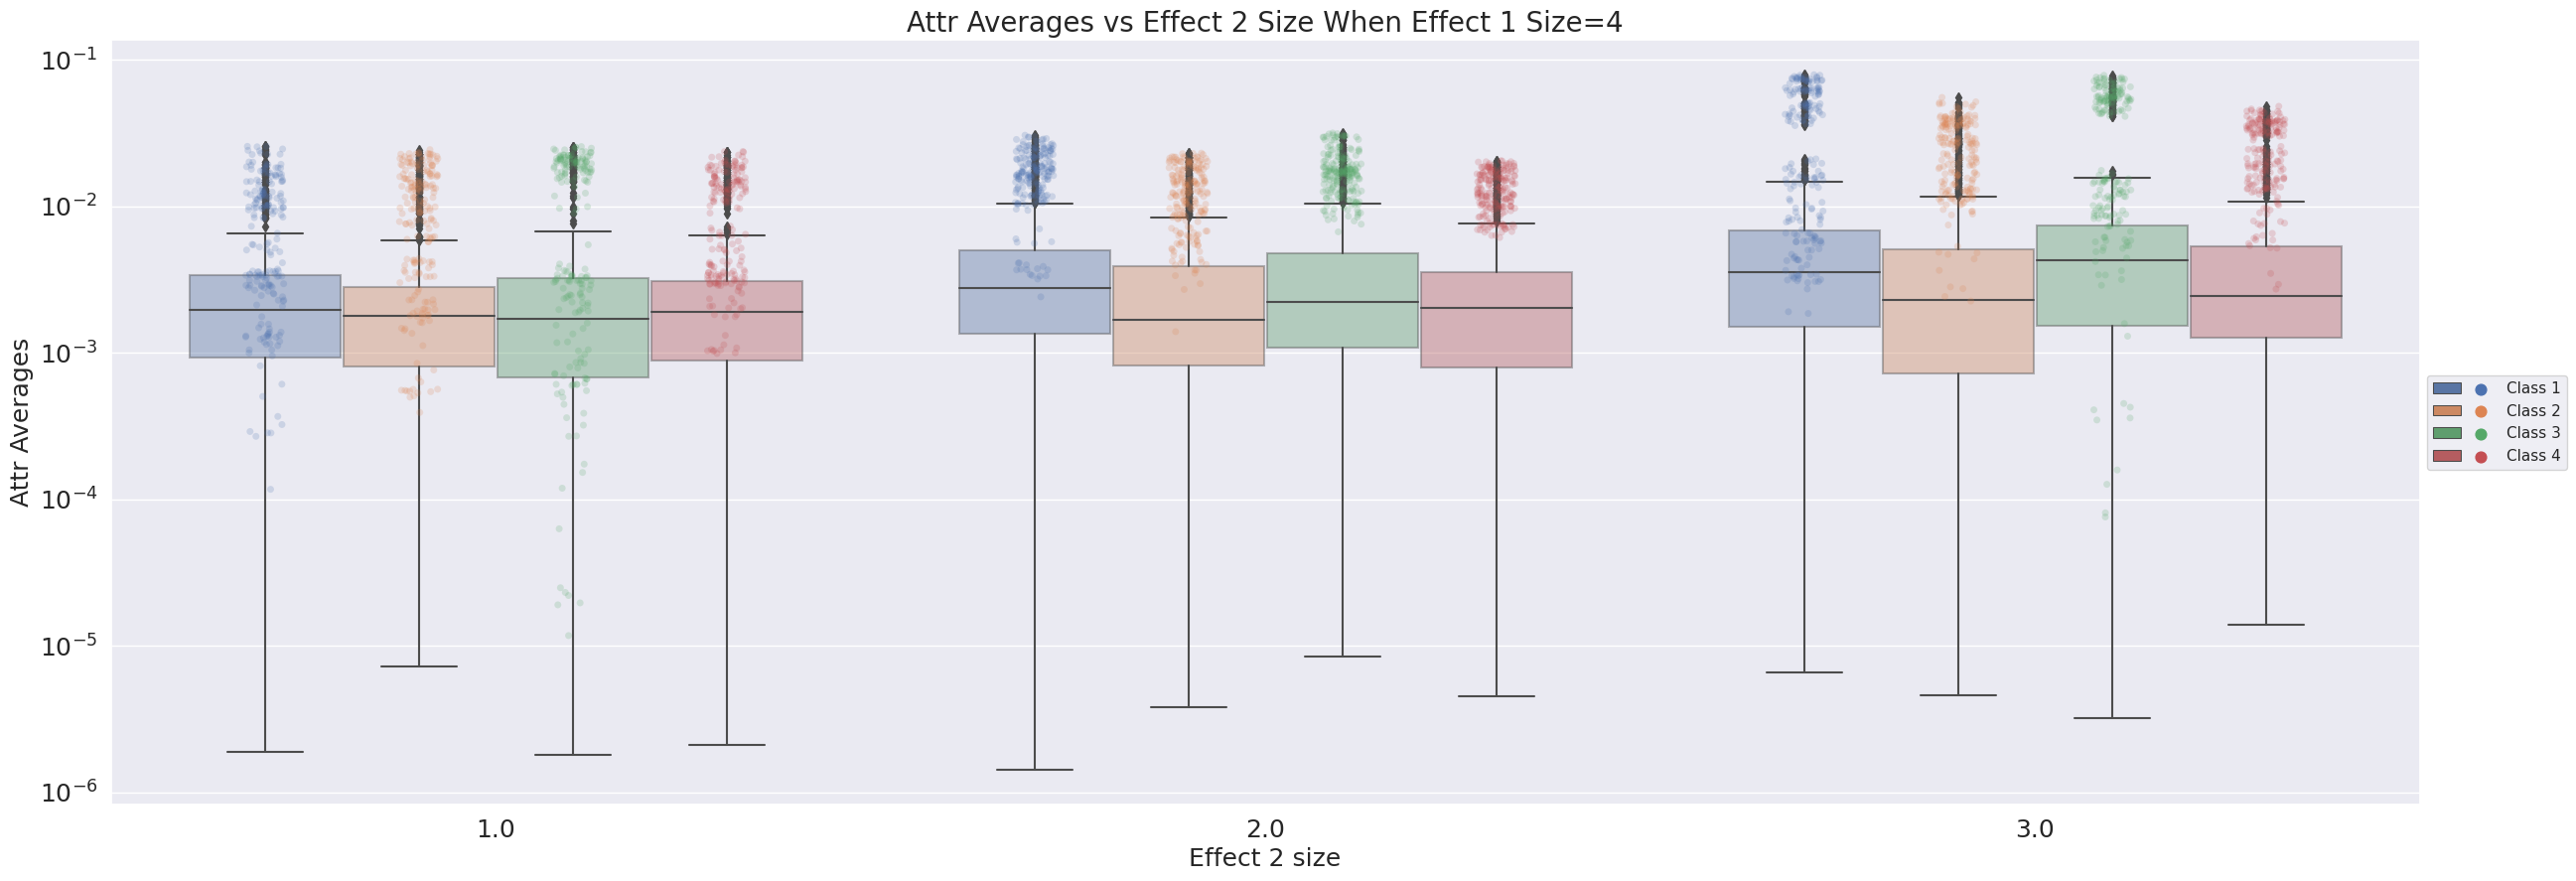

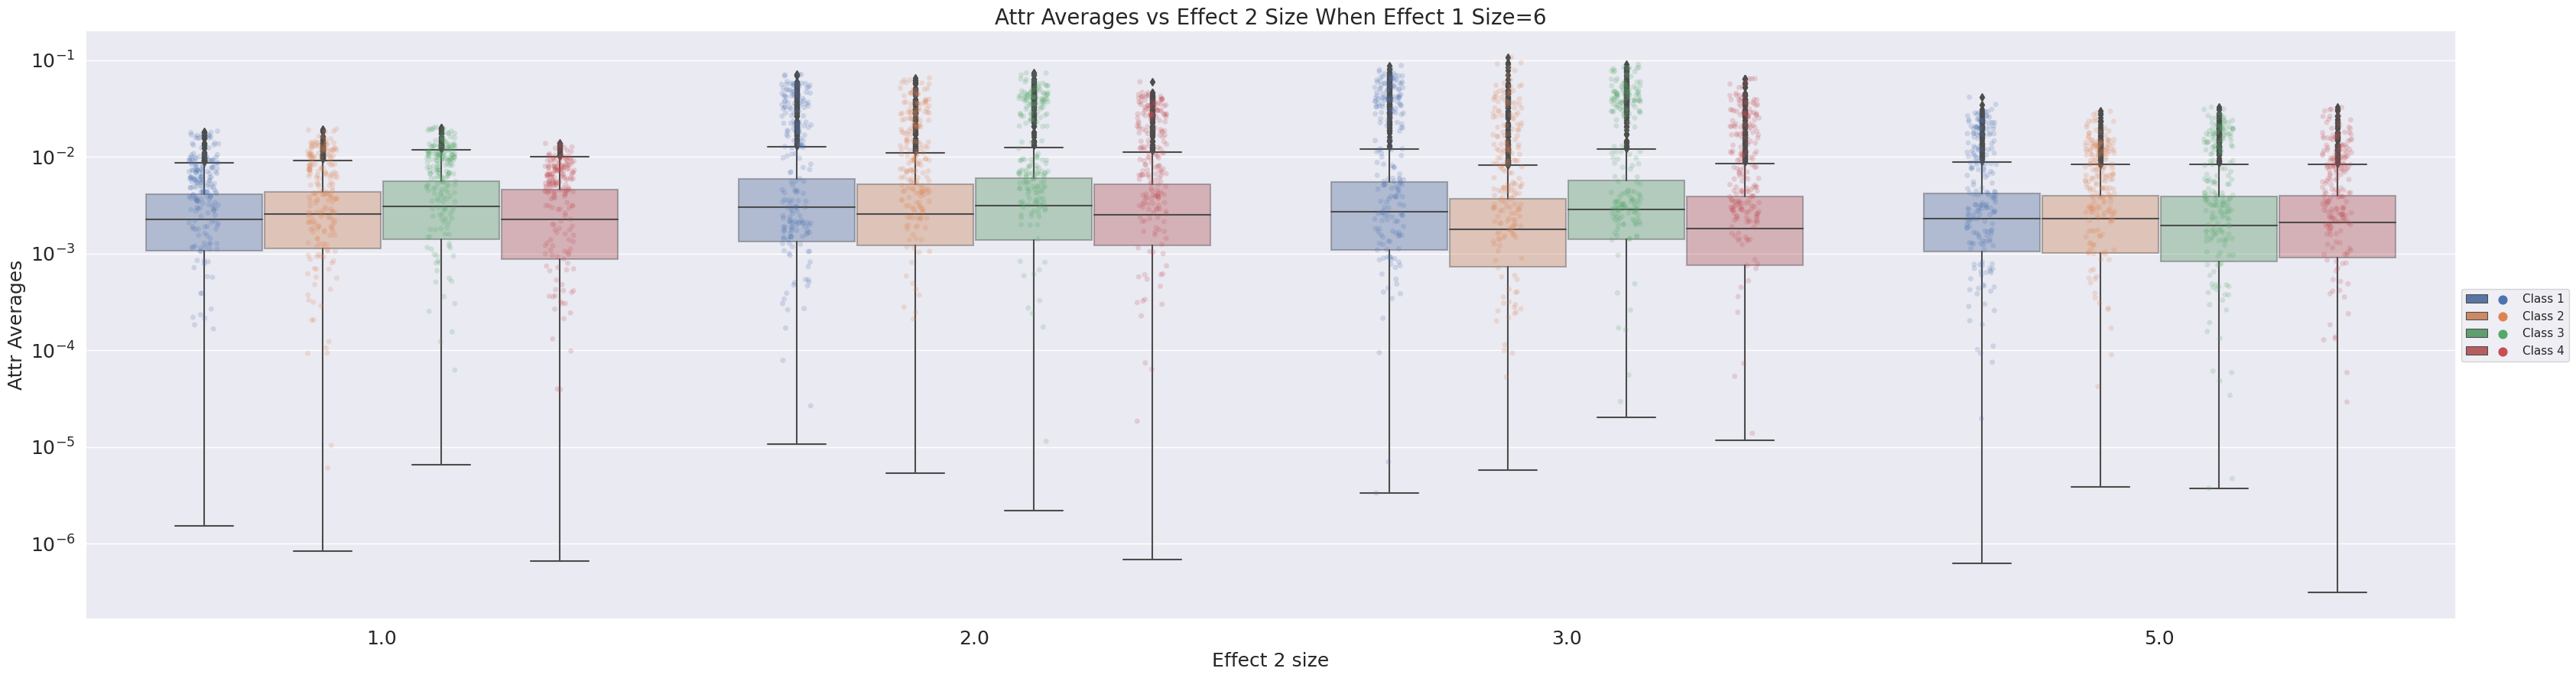

In [9]:
os.makedirs('../figures/sim_data', exist_ok=True)
for main_effect in [2, 4, 6]:
    plot_4_cluster_agg(full_df[(full_df['Effect 1'] == main_effect)], 'Attr Averages', avg_over=False, set_y_log=True, plot_col='Effect 2',
                       title='Attr Averages vs Effect 2 Size When Effect 1 Size={}'.format(main_effect), fig_name='../figures/sim_data/AttrAvg_vs_E2_For_E1={}'.format(main_effect))

## Make Table

In [10]:
c1 = pvals_df['mean of sig attrs'].combine(pvals_df['std of sig attrs'], lambda x, y: '${:.4f} \pm {:.4f}$'.format(x, y))
c2 = pvals_df['mean of non-sig attrs'].combine(pvals_df['std of non-sig attrs'], lambda x, y: '${:.4f} \pm {:.4f}$'.format(x, y))

In [11]:
pd.options.display.float_format = '{:.4f}'.format
pvals_df['attr p-val'] = pvals_df['attr p-val'].apply(lambda x: '$<$ 1e-4' if x < 1e-4 else x)
pvals_df['feat p-val'] = pvals_df['feat p-val'].apply(lambda x: '$<$ 1e-4' if x < 1e-4 else x)
pvals_df['mean sig attr +- sd'] = c1
pvals_df['mean non-sig attr +- sd'] = c2

In [12]:
print(pvals_df[['Effect 1', 'Effect 2', 'class', 'mean sig attr +- sd', 'mean non-sig attr +- sd', 'attr p-val']].to_latex(index=False, escape=False))

\begin{tabular}{rrrlll}
\toprule
 Effect 1 &  Effect 2 &  class & mean sig attr +- sd & mean non-sig attr +- sd & attr p-val \\
\midrule
        2 &         1 &      1 & $0.0044 \pm 0.0027$ &     $0.0007 \pm 0.0006$ &   $<$ 1e-4 \\
        2 &         1 &      2 & $0.0041 \pm 0.0022$ &     $0.0007 \pm 0.0005$ &   $<$ 1e-4 \\
        2 &         1 &      3 & $0.0054 \pm 0.0039$ &     $0.0009 \pm 0.0007$ &   $<$ 1e-4 \\
        2 &         1 &      4 & $0.0046 \pm 0.0030$ &     $0.0007 \pm 0.0006$ &   $<$ 1e-4 \\
        4 &         1 &      1 & $0.0083 \pm 0.0067$ &     $0.0018 \pm 0.0012$ &   $<$ 1e-4 \\
        4 &         1 &      2 & $0.0101 \pm 0.0071$ &     $0.0016 \pm 0.0009$ &   $<$ 1e-4 \\
        4 &         1 &      3 & $0.0105 \pm 0.0090$ &     $0.0018 \pm 0.0014$ &     0.0002 \\
        4 &         1 &      4 & $0.0095 \pm 0.0065$ &     $0.0016 \pm 0.0010$ &   $<$ 1e-4 \\
        4 &         2 &      1 & $0.0169 \pm 0.0065$ &     $0.0025 \pm 0.0016$ &   $<$ 1e-4 \\
        